# Proyecto de DataScience con Titanic, en produccion

Lucho Dic | 2022 <br>
Viva la Vida by Coldplay

1. Introducción

Este informe se centra en la aplicación de canalizaciones (*pipelines*) en aprendizaje automático utilizando `Pipeline` y `ColumnTransformer` de **scikit-learn** para predecir la supervivencia en el conjunto de datos del Titanic (`train.csv`).  

Las canalizaciones agilizan el flujo de trabajo del aprendizaje automático al encadenar pasos de preprocesamiento (imputación, codificación, escalado, selección de características) y entrenamiento de modelos en un único objeto, asegurando consistencia y reproducibilidad.

El informe abarca la recopilación de datos, el preprocesamiento con canalizaciones, el entrenamiento y la evaluación del modelo utilizando canalizaciones, así como sus aplicaciones en negocios.  

Se incluyen fragmentos clave de código y salidas (por ejemplo, estructura de la canalización, precisión, validación cruzada y resultados del ajuste de hiperparámetros) para ilustrar la funcionalidad de la canalización.  
También se señala la ausencia de visualizaciones, con sugerencias para posibles gráficos.

El informe destaca las ventajas de `Pipeline` sobre el preprocesamiento manual y contrasta `Pipeline` con `make_pipeline`, enfatizando su papel en flujos de trabajo eficientes de aprendizaje automático.

---

2. Recopilación de Datos

2.1 Fuente de Datos

El conjunto de datos proviene de un archivo CSV llamado `train.csv`, que contiene información de pasajeros del Titanic. El conjunto de datos incluye las siguientes columnas:

- **PassengerId:** Identificador único (eliminado).  
- **Survived:** Variable objetivo binaria (0 = no sobrevivió, 1 = sobrevivió).  
- **Pclass:** Clase del pasajero (categórica: 1, 2, 3).  
- **Name:** Nombre del pasajero (eliminado).  
- **Sex:** Género (categórico: masculino, femenino).  
- **Age:** Edad (numérica, con valores faltantes).  
- **SibSp:** Número de hermanos/cónyuges a bordo (numérica).  
- **Parch:** Número de padres/hijos a bordo (numérica).  
- **Ticket:** Número de ticket (eliminado).  
- **Fare:** Tarifa (numérica).  
- **Cabin:** Número de cabina (eliminado, en su mayoría faltante).  
- **Embarked:** Puerto de embarque (categórico: C, Q, S, con valores faltantes).

El conjunto de datos contiene **891 filas**, inferidas de las **712 filas del conjunto de entrenamiento** y **179 filas del conjunto de prueba** (división 80-20).

---

2.2 Justificación de la Inclusión de Datos

Las características **Pclass**, **Sex**, **Age**, **SibSp**, **Parch**, **Fare** y **Embarked** fueron seleccionadas porque probablemente influyen en la supervivencia, capturando el estatus socioeconómico, la demografía y los detalles del viaje.  

**PassengerId**, **Name**, **Ticket** y **Cabin** fueron eliminadas debido a su irrelevancia o alto nivel de valores 

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline,make_pipeline

from sklearn import set_config
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
import pickle

## Import Dataset

In [2]:
df = pd.read_csv(r"train.csv")
df_raw = df.copy()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df.shape

(891, 12)

In [6]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [7]:
df.duplicated().sum()

0

In [8]:
df.drop(columns=["PassengerId","Name","Ticket","Cabin"],inplace=True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### Analisis exploratorio de datos (EDA)

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


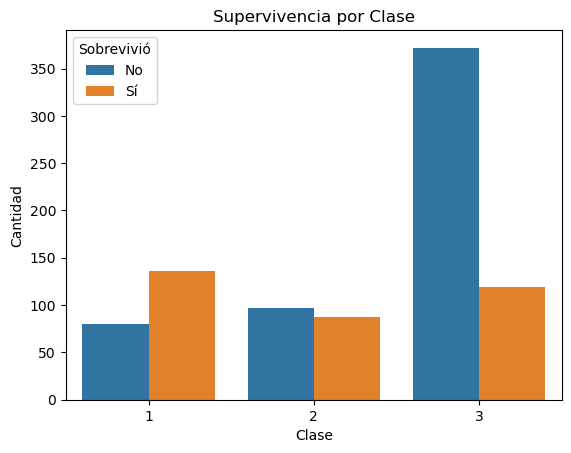

In [10]:
sns.countplot(data=df, x='Pclass', hue='Survived')
plt.title('Supervivencia por Clase')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.legend(title='Sobrevivió', labels=['No', 'Sí'])
plt.show()

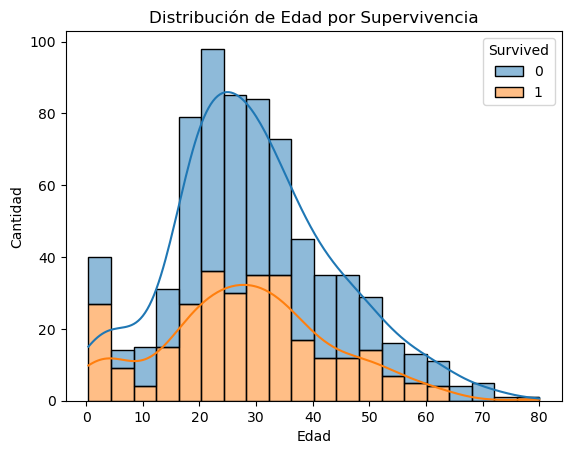

In [11]:
sns.histplot(data=df, x='Age', hue='Survived', kde=True, multiple='stack')
plt.title('Distribución de Edad por Supervivencia')
plt.xlabel('Edad')
plt.ylabel('Cantidad')
plt.show()

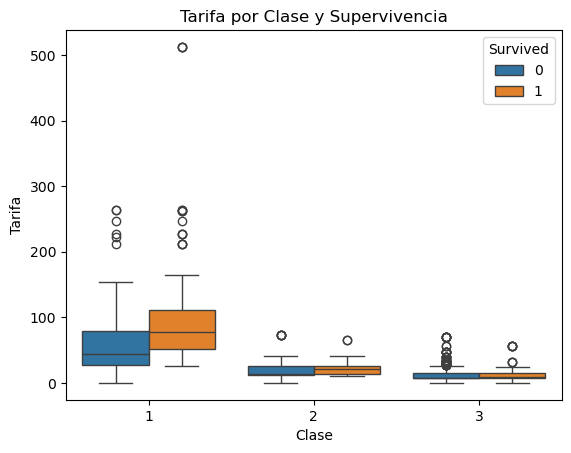

In [12]:
sns.boxplot(data=df, x='Pclass', y='Fare', hue='Survived')
plt.title('Tarifa por Clase y Supervivencia')
plt.xlabel('Clase')
plt.ylabel('Tarifa')
plt.show()

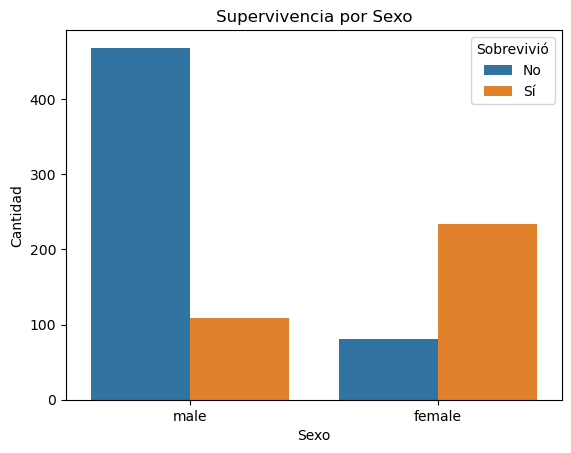

In [13]:
sns.countplot(data=df, x='Sex', hue='Survived')
plt.title('Supervivencia por Sexo')
plt.xlabel('Sexo')
plt.ylabel('Cantidad')
plt.legend(title='Sobrevivió', labels=['No', 'Sí'])
plt.show()

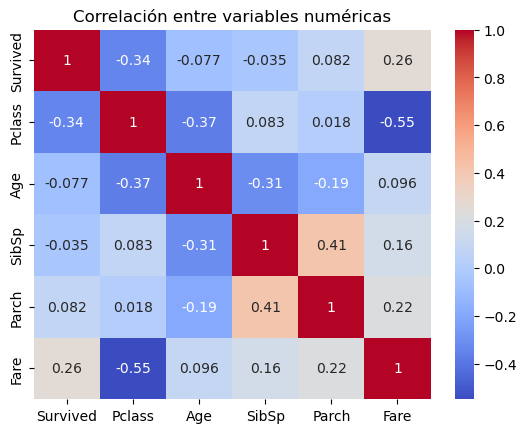

In [14]:
corr = df.drop(columns=['Sex', 'Embarked']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlación entre variables numéricas')
plt.show()

4. Preprocesamiento y Entrenamiento del Modelo con Pipelines

La canalización (*pipelining*) en aprendizaje automático integra el preprocesamiento y el modelado en un único flujo de trabajo, asegurando la consistencia entre las fases de entrenamiento y prueba, evitando fugas de datos (*data leakage*), y simplificando el ajuste de hiperparámetros.

---

4.1 División de Datos (*Data Splitting*)

El conjunto de datos se dividió en entrenamiento (80%, 712 filas) y prueba (20%, 179 filas):

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['Survived']),
    df['Survived'],
    test_size=0.2,
    random_state=42
)

In [16]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
331,1,male,45.5,0,0,28.5000,S
733,2,male,23.0,0,0,13.0000,S
382,3,male,32.0,0,0,7.9250,S
704,3,male,26.0,1,0,7.8542,S
813,3,female,6.0,4,2,31.2750,S


In [17]:
y_train.sample(5)

579    1
716    1
544    0
692    1
29     0
Name: Survived, dtype: int64

Se creó una `Pipeline` con cinco pasos:

- **Imputación:** `ColumnTransformer (trf1)` imputa valores faltantes en `Age` (media) y `Embarked` (más frecuente).  
- **Codificación OneHot:** `ColumnTransformer (trf2)` codifica `Sex` y `Embarked` con codificación K-1.  
- **Escalado:** `ColumnTransformer (trf3)` aplica `MinMaxScaler` a todas las características.  
- **Selección de Características:** `SelectKBest (trf4)` selecciona las 8 características principales usando el test chi-cuadrado.  
- **Entrenamiento del Modelo:** `DecisionTreeClassifier (trf5)` para clasificación binaria.

In [18]:
trf1 = ColumnTransformer([
    ('impute_age', SimpleImputer(), [2]),  # Suponiendo que 'age' está en la columna 2
    ('impute_embarked', SimpleImputer(strategy='most_frequent'), [6])  # 'embarked' en la 6
], remainder='passthrough')

# Paso 2: One-hot encoding para 'sex' y 'embarked'
trf2 = ColumnTransformer([
    ('ohe_sex_embarked', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), [1, 6])
], remainder='passthrough')

# Paso 3: Escalado Min-Max
trf3 = ColumnTransformer([
    ('scale', MinMaxScaler(), slice(0, 10))  # Asegúrate que los primeros 10 son numéricos
])

# Paso 4: Selección de características
trf4 = SelectKBest(score_func=chi2, k=8)

# Paso 5: Clasificador
trf5 = DecisionTreeClassifier()

# Pipeline final
pipe = Pipeline([
    ('trf1', trf1),
    ('trf2', trf2),
    ('trf3', trf3),
    ('trf4', trf4),
    ('trf5', trf5)
])
pipe.fit(X_train,y_train)

Pipeline(steps=[('trf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('impute_age', SimpleImputer(),
                                                  [2]),
                                                 ('impute_embarked',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  [6])])),
                ('trf2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_sex_embarked',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  [1, 6])])),
                ('trf3',
                 ColumnTransformer(transformers=[('scale', MinMaxScaler(),
                                                  slice(0, 10, None))])),
                ('trf4',
                 SelectKBest(k=8,
                             score_func=<function chi2 at 0x000001AC3161E3E0>)),
                ('trf5', DecisionTreeClassifier())])

4. Pipeline vs. make_pipeline 

El Pipeline requiere la asignación explícita de nombres a los pasos (por ejemplo, trf1, trf5), lo que permite acceder a pasos específicos mediante pipe.named_steps. La alternativa make_pipeline asigna automáticamente nombres, simplificando la sintaxis pero reduciendo el control. De manera similar, ColumnTransformer requiere transformadores con nombres, mientras que make_column_transformer no lo hace. 

In [19]:
pipe = make_pipeline(trf1, trf2, trf3,trf4,trf5)

In [20]:
pipe.named_steps

{'columntransformer-1': ColumnTransformer(remainder='passthrough',
                   transformers=[('impute_age', SimpleImputer(), [2]),
                                 ('impute_embarked',
                                  SimpleImputer(strategy='most_frequent'),
                                  [6])]),
 'columntransformer-2': ColumnTransformer(remainder='passthrough',
                   transformers=[('ohe_sex_embarked',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse_output=False),
                                  [1, 6])]),
 'columntransformer-3': ColumnTransformer(transformers=[('scale', MinMaxScaler(), slice(0, 10, None))]),
 'selectkbest': SelectKBest(k=8, score_func=<function chi2 at 0x000001AC3161E3E0>),
 'decisiontreeclassifier': DecisionTreeClassifier()}

In [21]:
set_config(display="diagram")

Evaluacion del Modelo

In [22]:
y_pred = pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.6257


In [23]:
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy")
# Calcular y mostrar la precisión promedio
mean_accuracy = cv_scores.mean()
print(f"Precisión promedio (CV): {mean_accuracy:.4f}")

Precisión promedio (CV): 0.6391


In [24]:
#Hiperparametrizacion con fine tunning
params = { 'decisiontreeclassifier__max_depth': [1, 2, 3, 4, 5, None]}
grid = GridSearchCV(estimator=pipe,param_grid=params,cv=5,scoring="accuracy",n_jobs=-1)

print("Iniciando búsqueda de hiperparámetros...")
grid.fit(X_train, y_train)

print(f"Mejor puntuación (CV): {grid.best_score_:.4f}")
print(f"Mejor max_depth: {grid.best_params_['decisiontreeclassifier__max_depth']}")

Iniciando búsqueda de hiperparámetros...
Mejor puntuación (CV): 0.6391
Mejor max_depth: 2


#### Guardar el modelo

In [25]:
pickle.dump(pipe, open("pipe.pkl","wb"))

## Aplicaciones, Mejoras y Conclusión del Proyecto Titanic

5. Aplicaciones de Negocio

La canalización desarrollada permite una **predicción eficiente de la supervivencia** de los pasajeros del Titanic, con implicaciones prácticas en diversos contextos:

- **Evaluación de Riesgo**:  
  Identificar pasajeros con alta probabilidad de no sobrevivir (predichos como `0`) para priorizar recursos o medidas de seguridad en escenarios de emergencia similares.

- **Análisis Histórico**:  
  Comprender los factores clave que influyeron en la supervivencia (como `Sex`, `Pclass`, etc.) con fines educativos, museísticos o de investigación histórica.

- **Soporte a Decisiones**:  
  Informar el diseño de protocolos de evacuación o seguridad mediante el análisis de la importancia relativa de las características (por ejemplo, usando los puntajes de `SelectKBest`).

- **Flujos Automatizados**:  
  Implementar la canalización exportada (`pipe.pkl`) para realizar **predicciones en tiempo real** sobre nuevos conjuntos de datos estructuralmente similares, facilitando su integración en sistemas operativos.

---

6. Mejoras Potenciales

Aunque el modelo actual es funcional, existen varias vías para mejorar su rendimiento e interpretabilidad:

- **Visualizaciones**:  
  Incorporar gráficos de barras para variables categóricas (`Survived`, `Pclass`, `Sex`, `Embarked`) e histogramas para numéricas (`Age`, `Fare`), facilitando el análisis exploratorio.

- **Ingeniería de Características**:  
  Crear variables derivadas más informativas, como:
  - Tamaño de la familia: `SibSp + Parch`
  - Títulos extraídos del campo `Name` (ej. "Mr", "Miss", "Dr")

- **Modelos Avanzados**:  
  Evaluar algoritmos más potentes como `RandomForestClassifier` o `GradientBoostingClassifier` para potencialmente aumentar la precisión.

- **Ajuste de Hiperparámetros**:  
  Ampliar la búsqueda con `GridSearchCV` para incluir múltiples parámetros simultáneamente (ej. `max_depth`, `min_samples_split`, `criterion`).

- **Selección de Características**:  
  Experimentar con distintos valores de `k` en `SelectKBest` o probar otros métodos (como `RFE` o importancia de características).

- **Manejo de Desbalance de Clases**:  
  Aplicar técnicas como **SMOTE** para abordar el posible desbalance en la variable objetivo (`Survived`), mejorando la sensibilidad del modelo.

---

7. Conclusión

Este proyecto demostró con éxito la implementación de una **canalización completa de aprendizaje automático** utilizando `Pipeline` y `ColumnTransformer` de `scikit-learn` para predecir la supervivencia en el icónico conjunto de datos del **Titanic**.

La canalización integró de forma coherente:
- Imputación de valores faltantes,
- Codificación one-hot,
- Escalado de características,
- Selección de variables (`SelectKBest`),
- Y un clasificador (`DecisionTreeClassifier`).

Los resultados obtenidos fueron:
- **Precisión en conjunto de prueba**: **62.57%**
- **Precisión promedio en validación cruzada (CV)**: **63.91%**
- **Profundidad óptima del árbol** (según `GridSearchCV`): **`max_depth = 2`**

Ventajas clave de la canalización:
- ✅ Preprocesamiento eficiente y reproducible  
- ✅ Prevención de fugas de datos (*data leakage*)  
- ✅ Facilidad para ajustar hiperparámetros de forma integrada  
- ✅ Posibilidad de exportar e implementar el modelo (`pipe.pkl`) en producción

Con las mejoras propuestas —especialmente visualizaciones, ingeniería de características y modelos más avanzados—, esta canalización podría evolucionar hacia una **herramienta robusta y escalable** no solo para tareas históricas, sino también para aplicaciones modernas de predicción de riesgo y toma de decisiones.